# Scripts 

In [132]:
%run '../shared-code/utils.py' 

# Dependencies

In [107]:
import pandas as pd 
import joblib 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np 

%matplotlib inline 

# Load & Process data 

In [108]:
data_pipe=joblib.load('../pipelines/data_pipeline.pkl')

In [109]:
df_tr=pd.read_csv('../data/train.csv')
df_test=pd.read_csv('../data/test.csv')
X_tr,Y_tr=df_tr.drop(TARGET_COL,axis=1),df_tr[TARGET_COL]
X_test,Y_test=df_test.drop(TARGET_COL,axis=1),df_test[TARGET_COL]

In [110]:
data_pipe.fit(X_tr)
X_tr_proc,X_test_proc=data_pipe.transform(X_tr),data_pipe.transform(X_test)

# Tree 

## Post processing prunning 

Ke se obidime da najdeme dobra konfiguracija za max_depth, min_samples_leaf. Ovie 2 parametri ke ni se najdobri za regression problem, bidejki min_samples_leaf osigurat deka ke imat dovolno samples vo leaf za odluka, dodeka max_depth ke osigurat deka nemat preterano da splitvime. Max_depth nekako ne me bendisvit deka mozda nekoj cases ke mu trebat pojke splitvenje, no sepak ke se postignit generazliacija. Spored to ednash ke probame samo so min_samples_leaf, ednash so 2te zaedno. 

In [111]:
tree=DecisionTreeRegressor() 
param_space_min_samples=np.linspace(start=0.01,stop=0.8,num=50)
fine_tuner_min_samples_leaf=GridSearchCV(
    estimator=tree,
    cv=10,
    scoring=house_pricing_metric,
    param_grid={
        "min_samples_leaf": param_space_min_samples 
    }
)
fine_tuner_min_samples_leaf.fit(X_tr_proc,Y_tr)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_leaf': array([0.01      , 0.02612245, 0.0422449 , 0.05836735, 0.0744898 ,
       0.09061224, 0.10673469, 0.12285714, 0.13897959, 0.15510204,
       0.17122449, 0.18734694, 0.20346939, 0.21959184, 0.23571429,
       0.25183673, 0.26795918, 0.28408163, 0.30020408, 0.31632653,
       0.33244898, 0.34857143, 0.36469388, 0.38081633, 0.39693878,
       0.41306122, 0.42918367, 0.44530612, 0.46142857, 0.47755102,
       0.49367347, 0.50979592, 0.52591837, 0.54204082, 0.55816327,
       0.57428571, 0.59040816, 0.60653061, 0.62265306, 0.63877551,
       0.65489796, 0.67102041, 0.68714286, 0.70326531, 0.71938776,
       0.7355102 , 0.75163265, 0.7677551 , 0.78387755, 0.8       ])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [123]:
"Best score {}".format(-1 * fine_tuner_min_samples_leaf.best_score_)

'Best score 0.18885068075119293'

In [120]:
reverse_mse=lambda x: -1 * x 

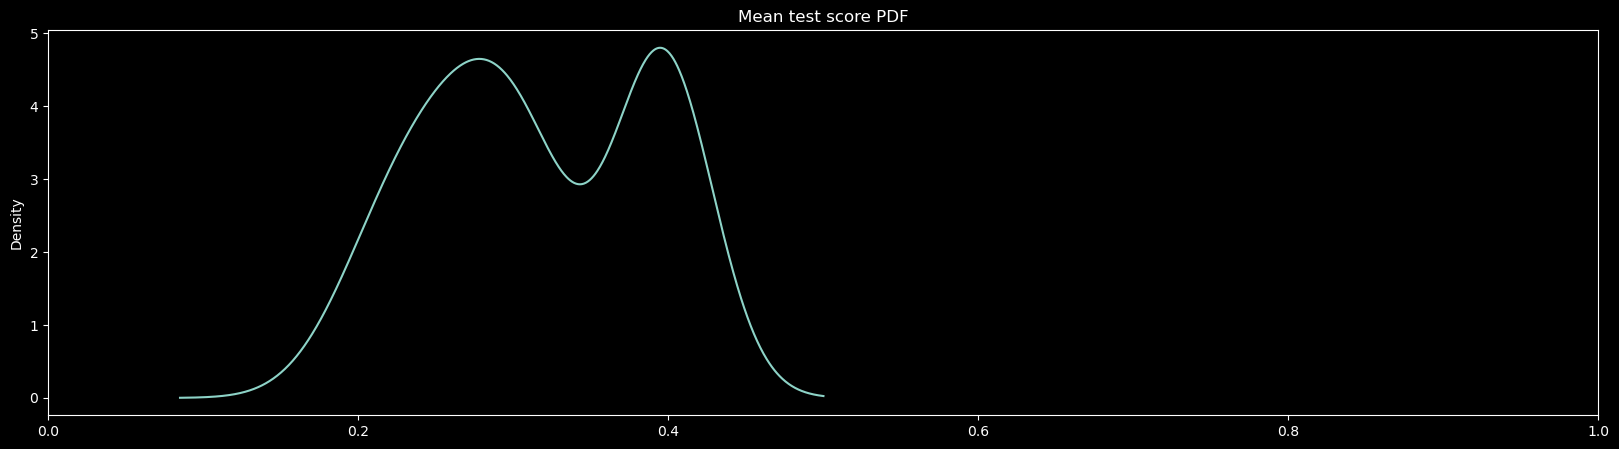

In [122]:
res=pd.DataFrame(fine_tuner_min_samples_leaf.cv_results_)
ax=res['mean_test_score'].map(reverse_mse).plot.kde(title='Mean test score PDF',figsize=(20,5))
ax.set_xlim((0,1))
plt.show()

Znachit najcesto modelive imat preformansi vo (0.2,0.3) i (0.35,0.45)

Da vidime dali nekoj subset na data e biten za trainingot. To znachit dali kaj site dataset generalno imat ista distribucija na preformansi ili pak nekade e mnogu porazlichno, sho bi indiciralo deka train datasetot e dosta povolen za modelot vo takov slucaj. 

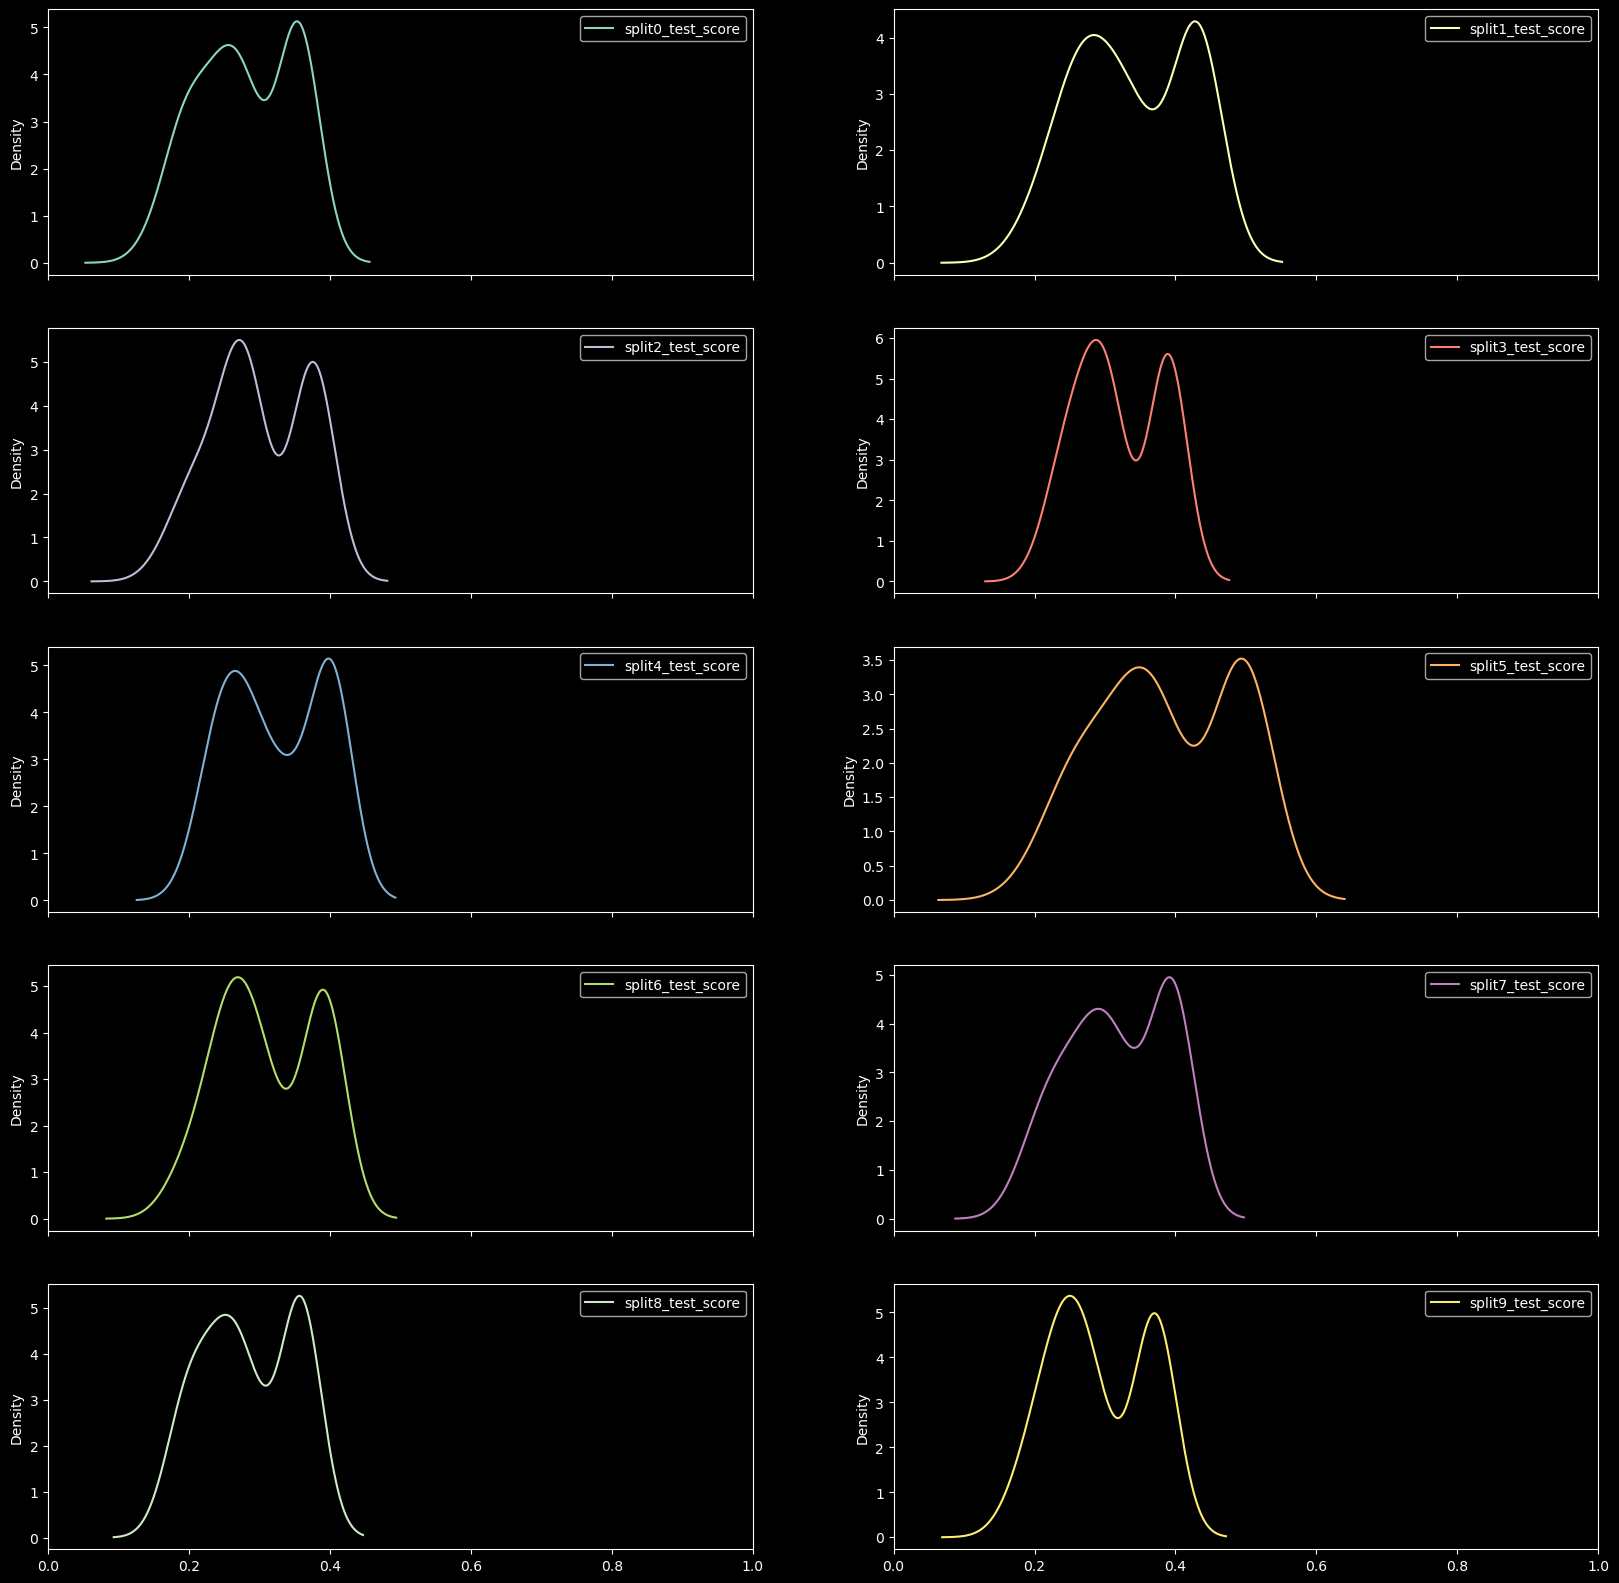

In [125]:
axs=res[[f'split{i}_test_score' for i in range(10)]].map(reverse_mse)\
    .plot.kde(subplots=True,layout=(5,2),figsize=(20,20))
for ax in axs:
    ax=ax[0]
    ax.set_xlim((0,1))
plt.show()

Spored distribucijata ne gledame nekoja prefrenca vo odnos na subset of datasetot. 

In [240]:
tree = DecisionTreeRegressor()
param_space_min_samples = np.linspace(start=0.00001, stop=1,num=80)
param_space_max_depth =np.linspace(
    start=int(0.1*X_tr_proc.shape[1]),
    stop=int(1.2*X_tr_proc.shape[1]),
    dtype=np.int64
) 
fine_tuner_all = GridSearchCV(
    estimator=tree,
    scoring=house_pricing_metric,
    cv=10,
    param_grid={
        "min_samples_leaf": param_space_min_samples,
        "max_depth": param_space_max_depth,
    },
    n_jobs=-1,
)
fine_tuner_all.fit(X_tr_proc, Y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 40000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_p

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 7,  8, 10, 12, 14, 15, 17, 19, 21, 22, 24, 26, 28, 30, 31, 33, 35,
       37, 38, 40, 42, 44, 46, 47, 49, 51, 53, 54, 56, 58, 60, 62, 63, 65,
       67, 69, 70, 72, 74, 76, 78, 79, 81, 83, 85, 86, 88, 90, 92, 94]),
                         'min_samples_leaf': array([1.00000000e-05, 1.26681013e-02, 2.53262025e-02, 3.79843038e-02,
       5.06424051e-02, 6.330...
       7.59496076e-01, 7.72154177e-01, 7.84812278e-01, 7.97470380e-01,
       8.10128481e-01, 8.22786582e-01, 8.35444684e-01, 8.48102785e-01,
       8.60760886e-01, 8.73418987e-01, 8.86077089e-01, 8.98735190e-01,
       9.11393291e-01, 9.24051392e-01, 9.36709494e-01, 9.49367595e-01,
       9.62025696e-01, 9.74683797e-01, 9.87341899e-01, 1.00000000e+00])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [245]:
'Best score {}'.format(-1 * fine_tuner_all.best_score_)

'Best score 0.18685772389973337'

In [246]:
best_tree=fine_tuner_all.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.012668101265822785)

In [247]:
results=pd.DataFrame(fine_tuner_all.cv_results_)
tmp=results=pd.concat([
    results[['params','mean_test_score']]['params'].apply(pd.Series),
    results['mean_test_score'].apply(reverse_mse)
],axis=1)

In [265]:
tmp

,max_depth,min_samples_leaf,mean_test_score
0,7.0,0.000010,0.202757
1,7.0,0.012668,0.187365
2,7.0,0.025326,0.197516
3,7.0,0.037984,0.209169
4,7.0,0.050642,0.217768
...,...,...,...
3995,94.0,0.949368,0.396409
3996,94.0,0.962026,0.396409
3997,94.0,0.974684,0.396409
3998,94.0,0.987342,0.396409


In [266]:
vals=tmp['mean_test_score'].values

col_size=param_space_min_samples.shape[0]
row_size=param_space_max_depth.shape[0]

cv_scores=[[vals[i*col_size + j] for j in range(col_size)]
           for i in range(row_size)]
cv_scores[0] == tmp[tmp['max_depth']==7]['mean_test_score']

0      True
1      True
2      True
3      True
4      True
      ...  
75     True
76     True
77     True
78     True
79    False
Name: mean_test_score, Length: 80, dtype: bool

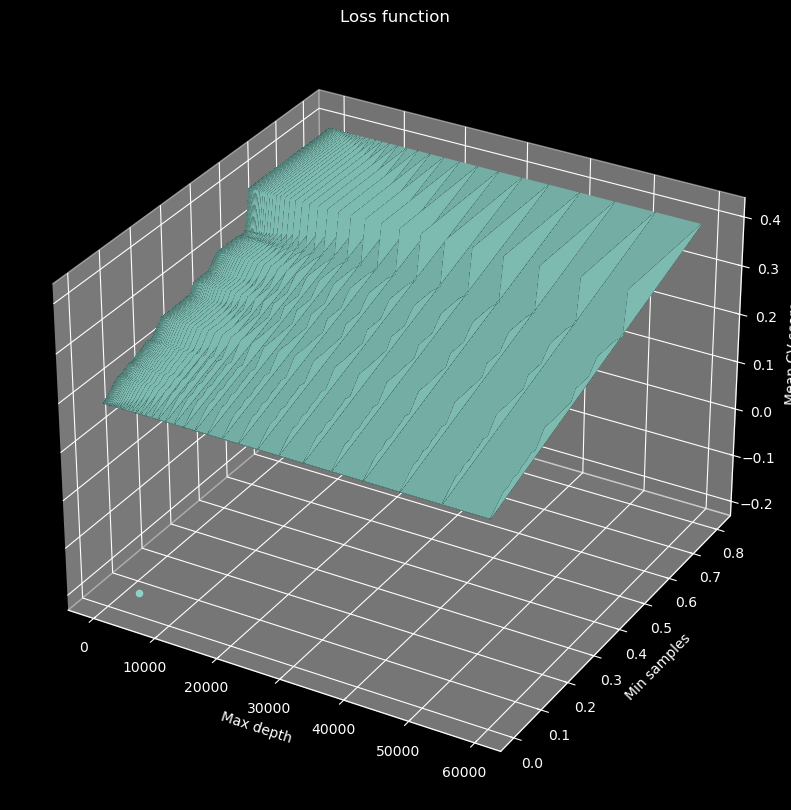

In [172]:
results=pd.DataFrame(fine_tuner_all.cv_results_)
results=pd.concat([
    results[['params','mean_test_score']]['params'].apply(pd.Series),
    results['mean_test_score'].apply(reverse_mse)
],axis=1)

max_depth_gird,min_samples_grid=np.meshgrid(results['max_depth'].values,results['min_samples_leaf'].values)
_,cv_scores=np.meshgrid(results['max_depth'],results['mean_test_score'])

plt.figure(figsize=(20,10))
ax=plt.axes(projection='3d')
ax.plot_surface(max_depth_gird,min_samples_grid,cv_scores)

ax.set_title("Loss function")
ax.set_xlabel("Max depth")
ax.set_ylabel("Min samples")
ax.set_zlabel("Mean CV score")

ax.scatter3D(
    fine_tuner_all.best_params_['max_depth'],
    fine_tuner_all.best_params_['min_samples_leaf'],
    fine_tuner_all.best_score_
)
plt.show() 

## Pre processing prunning

## PCA 

# Random forest